# Trabajo Práctico 2: Análisis con K-Nearest Neighbors (KNN) - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [3]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import normalizar_datos
from preprocessing import aplicar_one_hot_encoding

In [4]:
from funcionesAuxiliares import graficar_auc_roc
from funcionesAuxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo:

In [5]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test)

In [6]:
X, y = dividir_dataset(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train, X_test = normalizar_datos(X_train, X_test)

## Búsqueda de hiperparámetros
Definimos los mejores hiperparámetros mediante la siguiente función de búsqueda. Estos son la distancia, la métrica utilizada y K, que determina la cantidad de vecinos a tener en cuenta. Nos quedamos con la combinación que maximice la métrica de comparación utilizada, que es AUC-ROC.

In [7]:
def definir_mejores_hiperparametros(X, y):    
    metrics = []
    y_array=np.array(y)
    for distancia in ['uniform', 'distance']:
        for metrica in ['minkowski','cosine','chebyshev','correlation']:
            for k in [2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,65,70]: 
                kf = StratifiedKFold(n_splits=5)
                metricas_de_la_combinacion = []
                for fold_index, (train_index, test_index) in enumerate(kf.split(X, y_array)):
                    train_fold_actual = X.iloc[train_index].copy()
                    test_fold_actual = X.iloc[test_index].copy()
                    train_fold_actual, test_fold_actual = normalizar_datos(train_fold_actual, test_fold_actual)
                    knn = KNeighborsClassifier(n_neighbors=k, weights=distancia, metric=metrica)
                    knn.fit(train_fold_actual, y.iloc[train_index])
                    y_pred = knn.predict_proba(test_fold_actual)[:,1]
                    metricas_de_la_combinacion.append(roc_auc_score(y.iloc[test_index], y_pred))
                        
                metrics.append((k, distancia, metrica, np.mean(metricas_de_la_combinacion)))
                    
    df_metrics = pd.DataFrame(metrics, columns = ['cant_vecinos', 'distancia', 'metrica', 'rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]
    return mejor_combinacion

## Entrenamiento y predicción con el dataset original
Buscamos la mejor combinación de hiperparámetros para este dataset, con la función anteriormente mencionada.

In [8]:
mejor_combinacion = definir_mejores_hiperparametros(X, y)
print(mejor_combinacion)

    cant_vecinos distancia    metrica    rocauc
14            60   uniform  minkowski  0.898222


Observamos que la mejor combinación de hiperparámetros es la siguiente:

In [11]:
parametros_knn = mejor_combinacion.loc[:].values[0]
mejor_k = parametros_knn[0]
mejor_distancia = parametros_knn[1]
mejor_metrica = parametros_knn[2]
print(f'Mejor cantidad de vecinos (k): {mejor_k}')
print(f'Mejor distancia: {mejor_distancia}')
print(f'Mejor métrica: {mejor_metrica}')

Mejor cantidad de vecinos (k): 60
Mejor distancia: uniform
Mejor métrica: minkowski


Entrenamos KNN con esa mejor combinación:

In [12]:
knn = KNeighborsClassifier(n_neighbors = mejor_k, weights = mejor_distancia, metric = mejor_metrica)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=60)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

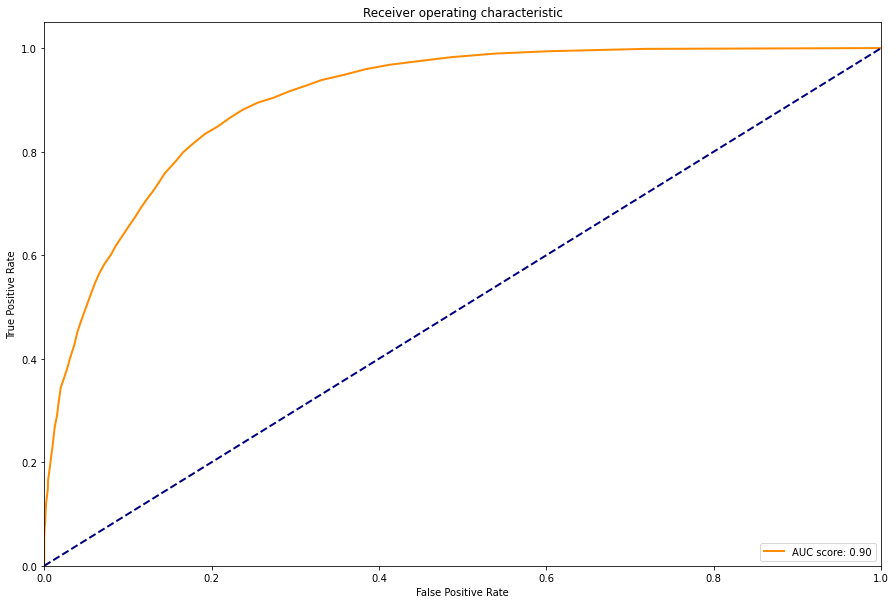

0.9015074213136609

In [14]:
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)[:,1]
graficar_auc_roc(y_test, y_pred_proba)

Podemos observar que el AUC score es muy alto (0.90), lo cual quiere decir que estamos frente a un buen clasificador. 

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [15]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.87      0.93      0.90      6159
   Tiene Alto Valor Adquisitivo       0.72      0.58      0.65      1982

                       accuracy                           0.84      8141
                      macro avg       0.80      0.76      0.77      8141
                   weighted avg       0.84      0.84      0.84      8141



Por último, mostramos la matriz de confusión correspondiente:

In [16]:
from funcionesAuxiliares import graficar_matriz_confusion

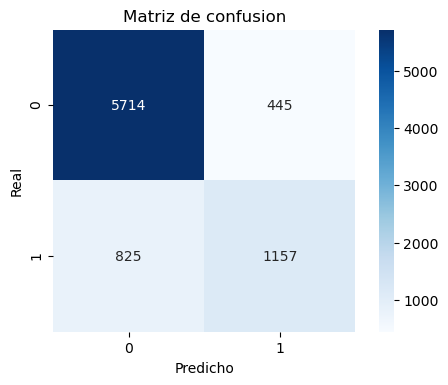

In [17]:
graficar_matriz_confusion(y_test, y_pred)

Podemos ver que el modelo clasifica muy bien las instancias con bajo valor adquisitivo, proporcionando un alto recall y precision para estas. Sin embargo, el recall para las instancias con altos ingresos no es muy alto (0.58), y, como se puede ver, predice mal muchas de estas instancias (825 instancias).

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [18]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [19]:
X_exp = expandir_dataset(X)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [20]:
mejor_combinacion = definir_mejores_hiperparametros(X_exp, y)

A continuación, vemos la mejor combinación de hiperparámetros obtenida.

In [21]:
parametros_knn = mejor_combinacion.loc[:].values[0]
mejor_k = parametros_knn[0]
mejor_distancia = parametros_knn[1]
mejor_metrica = parametros_knn[2]
print(f'Mejor cantidad de vecinos (k): {mejor_k}')
print(f'Mejor distancia: {mejor_distancia}')
print(f'Mejor métrica: {mejor_metrica}')

Mejor cantidad de vecinos (k): 45
Mejor distancia: uniform
Mejor métrica: minkowski


Entrenamos KNN con esa mejor combinación:

In [22]:
knn_expandido = KNeighborsClassifier(n_neighbors = mejor_k, weights = mejor_distancia, metric = mejor_metrica)
knn_expandido.fit(X_exp_train, y_exp_train)

KNeighborsClassifier(n_neighbors=45)

Y ahora hacemos que prediga sobre el dataset expandido. Graficamos también la curva ROC con su respectivo resultado en la métrica AUC-ROC.

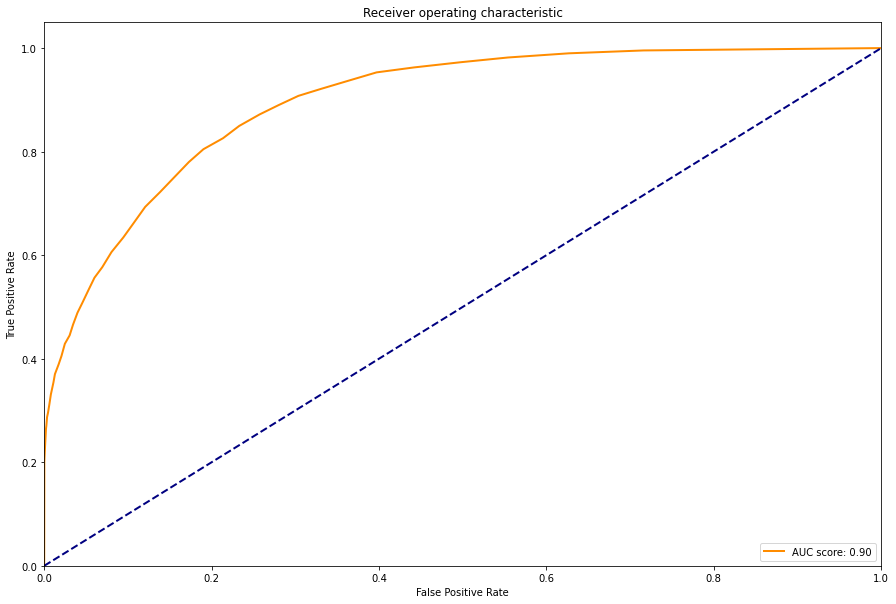

0.8962559856372558

In [23]:
y_pred = knn_expandido.predict(X_exp_test)
y_pred_proba = knn_expandido.predict_proba(X_exp_test)[:, 1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos ver que el resultado es bastante similar al del dataset original, aunque un poco inferior.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc. Allí vemos que disminuye muy levemente el f1-score para las instancias con alto valor adquisitivo, respecto a la predicción con el dataset original.

In [24]:
print(classification_report(y_exp_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.87      0.94      0.90      6159
   Tiene Alto Valor Adquisitivo       0.75      0.56      0.64      1982

                       accuracy                           0.85      8141
                      macro avg       0.81      0.75      0.77      8141
                   weighted avg       0.84      0.85      0.84      8141



Por último, mostramos la matriz de confusión correspondiente:

In [25]:
from funcionesAuxiliares import graficar_matriz_confusion

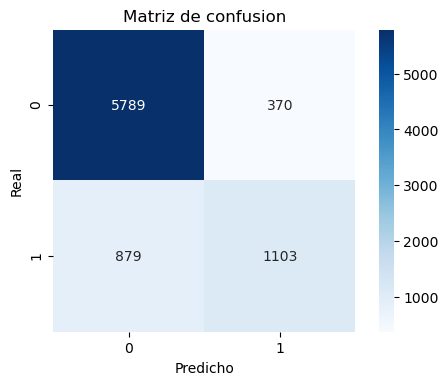

In [26]:
graficar_matriz_confusion(y_exp_test, y_pred)

Podemos ver que con el dataset ampliado, se obtuvo un resultado similar, aunque empeoró un poco la predicción de las instancias con alto valor adquisitivo, es decir, el recall.

## Predicción con el dataset de test holdout
A continuación, realizamos la predicción con KNN sobre el dataset de holdout sin expandir, ya que es el que nos dio un score más alto en la métrica AUC-ROC, y la escribimos al archivo 'KNN.csv'.

In [27]:
from funcionesAuxiliares import traer_holdout
from preprocessing import preparar_holdout
from funcionesAuxiliares import escribir_predicciones

In [28]:
holdout = traer_holdout()
ids, holdout = preparar_holdout(holdout)
holdout = aplicar_one_hot_encoding(holdout)

In [29]:
predicciones = knn.predict(holdout)
escribir_predicciones(ids, predicciones, "KNN")